In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import pypdf
import torch.nn.functional as F
import numpy as np
import os

In [2]:
df = pd.read_csv(r'C:\Users\Rick\lulu\Indian-Male-Names.csv',index_col=False)
df = df.drop('gender',axis = 1)
df

,name,race
0,barjraj,indian
1,ramdin verma,indian
2,sharat chandran,indian
3,birender mandal,indian
4,amit,indian
...,...,...
14840,buddha,indian
14841,mukesh,indian
14842,monu,indian
14843,govind prasad shahu,indian


In [5]:
df = df.drop('race',axis = 1)


In [30]:
df

,name
0,barjraj
1,ramdin verma
2,sharat chandran
3,birender mandal
4,amit
...,...
14840,buddha
14841,mukesh
14842,monu
14843,govind prasad shahu


In [6]:
df = df.drop_duplicates()

In [7]:
df.to_csv('Names_to_train.txt', index=False, header=False)

In [15]:
char_to_rem = '/\`0123456789@.,;}-()&"[]{}' + 'अआइईउऊएऐओऔऋअंकखगघड़चछजझञटठडढणतथदधनपफबभमयरलवशषसह' + 'ा' + 'ि' + 'ी' + 'ु' + 'ू' + 'े' + 'ो' + '्' + '\u200d' + '�'

def clean_char(name_of_folder):
    with open(name_of_folder, "r", encoding='utf-8') as f:
        content = f.read()
    cleaned_text = ''.join(char for char in content if char not in char_to_rem)
    
    lines = cleaned_text.split('\n') 
    processed_lines = []
    
    for line in lines:
        words = line.split()
        if words:  
            processed_line = ' '.join(words)  
            processed_lines.append(processed_line)

    final_output = '\n'.join(processed_lines)
    
    with open("cleaned_words.txt", "w", encoding='utf-8') as f:
        f.write(final_output)

clean_char("Names_to_train.txt")


<>:1: SyntaxWarning: invalid escape sequence '\`'
<>:1: SyntaxWarning: invalid escape sequence '\`'
C:\Users\Rick\AppData\Local\Temp\ipykernel_4044\3262600791.py:1: SyntaxWarning: invalid escape sequence '\`'
  char_to_rem = '/\`0123456789@.,;}-()&"[]{}' + 'अआइईउऊएऐओऔऋअंकखगघड़चछजझञटठडढणतथदधनपफबभमयरलवशषसह' + 'ा' + 'ि' + 'ी' + 'ु' + 'ू' + 'े' + 'ो' + '्' + '\u200d' + '�'


In [4]:
with open('cleaned_words.txt','r',encoding='utf-8')as f:
    data = f.read()
    words = data.splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}


In [5]:
block_size = 3 
X, Y = [], []
for w in words:
  #print(w)
  
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42)

In [42]:
generator = torch.manual_seed(6)
C = torch.randn(28,10)
w1= torch.randn((30,100))
b1 = torch.randn(100)
w2 = torch.randn((100,28))
b2 = torch.randn(28)
parameters = [C, w1, b1, w2, b2]

In [43]:
for p in parameters:
  p.requires_grad = True

In [44]:
sum(p.nelement() for p in parameters)

6208

In [45]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [78]:
lri = []
lossi = []
stepi = []

In [48]:
for i in range(10000):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (100,))
  
  # forward pass
  emb = C[X_train[ix]] # (32, 3, 4) (Minibatch for only 100 examples)
  h = torch.tanh(emb.view(-1, 30) @ w1 + b1) # (32, 200)
  logits = h @ w2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, y_train[ix])
  print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.001
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  #stepi.append(i)
  #lossi.append(loss.item())


1.6721872091293335
1.500200629234314
1.9040675163269043
1.9863086938858032
1.7463263273239136
1.7609214782714844
1.9556851387023926
1.7049963474273682
1.6102763414382935
1.65869140625
1.6699870824813843
1.5222129821777344
1.4803334474563599
1.778742790222168
1.6238740682601929
1.8786338567733765
1.7072149515151978
1.6469143629074097
1.4065338373184204
1.8819886445999146
1.6575959920883179
1.6195802688598633
1.7306971549987793
1.632455587387085
1.6827991008758545
1.662226915359497
1.776025652885437
1.7693759202957153
1.7372547388076782
1.8932678699493408
1.6188093423843384
1.8037532567977905
1.663040280342102
1.4863775968551636
1.6001324653625488
1.8642617464065552
1.6310505867004395
1.8376280069351196
1.7048094272613525
1.6309828758239746
1.6566369533538818
1.8073546886444092
1.8000317811965942
1.8056533336639404
1.419768214225769
1.6334385871887207
1.5909371376037598
1.690717339515686
1.8302847146987915
1.903998851776123
1.6126892566680908
1.8887031078338623
1.6309400796890259
1.64452

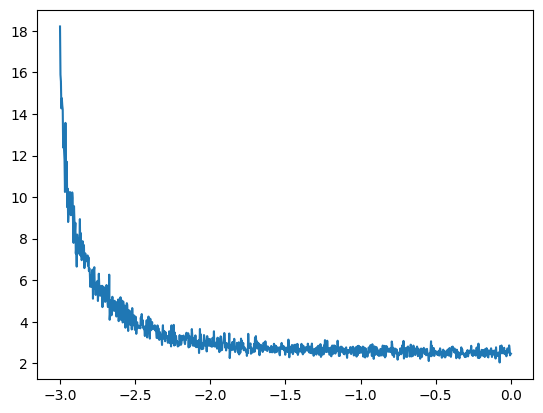

In [68]:
plt.plot(lri, lossi)

In [49]:
g = torch.Generator().manual_seed(6 + 10)

for _ in range(100):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits = h @ w2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

dhikash kumawanil aldendra kash ramunni singh.
taprakesh.
mohom burman.
pprabhish singh.
him paradesh kumar.
nawba.
preeen.
ranjaynay panikish kumar.
nitimansersad.
adul.
faran larma.
aijshal.
kumar.
sureen aray.
ash jinder jaisander pal shar pah shakar so agender singh il kumar.
bipak jaini.
ram sumikasij.
esh monu rawat.
sahu jha.
sar reji.
mahadur.
mohaprakesh rameitla.
sodanvir ahmad.
chitenkera shashman ditmani.
gud.
mohd.
lyan.
jayn ulmanjan pra bojlav chan.
kapa kumar.
sagarg.
esh mishuar husceepaksingh.
gulish maheszahul.
abdul jaish ramjeev kumar.
ram parvesh kumar.
sanja.
naiprash kumar.
man singh.
gaju paswar oor.
san yadav.
goravi.
sanil sahid.
jan.
surender singh sunil chankar.
jit shal.
shashud urf raj sharpal.
dhari.
sia.
anu.
satya lal.
shubhedrag.
deepal puratan.
suresh.
bhan.
sagdam.
medhit sohasharma.
abdultved kik ultan anshu kasharma.
shri.
peta mhari suheer.
him.
man.
bender singh.
parabhamid kald kish tawat kumar.
ish kumar kopender vikar sahgeena.
mhhagi.
ravi t